In [375]:
from argparse import Namespace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import warnings

warnings.filterwarnings('ignore')

In [376]:
# DATA_DIR_BASELINE = os.path.join('gait_entropy_dataset.csv')
# gait_entropy_dataset = pd.read_csv(DATA_DIR_BASELINE,usecols=['approximate_entropy','spectral_entropy','slope_entropy','label'])
# gait_entropy_dataset

DATA_DIR_BASELINE = os.path.join('gait_entropy_dataset.csv')
gait_entropy_dataset = pd.read_csv(DATA_DIR_BASELINE,usecols=['approximate_entropy','spectral_entropy','slope_entropy','label'])
# gait_entropy_dataset = pd.read_csv(DATA_DIR_BASELINE,usecols=['slope_entropy','label'])
# gait_entropy_dataset = pd.read_csv(DATA_DIR_BASELINE,usecols=['approximate_entropy','sample_entrpy','fuzzy_entropy','permutation_entropy','spectral_entropy','increment_entropy','slope_entropy','label'])
gait_entropy_dataset

,approximate_entropy,spectral_entropy,slope_entropy,label
0,1.525056,0.138583,0.013650,old_general
1,1.500463,0.143603,0.373253,old_general
2,1.487397,0.139913,0.012616,old_general
3,1.588065,0.138167,0.056292,old_general
4,1.543311,0.139601,0.027562,old_general
5,1.011157,0.179883,0.875531,old_parkinson
6,1.111986,0.169607,0.479560,old_parkinson
7,0.998590,0.186971,1.509583,old_parkinson
8,1.179881,0.173230,0.447566,old_parkinson
9,1.018661,0.169624,0.507993,old_parkinson


In [377]:
# add_parkinson = gait_entropy_dataset[gait_entropy_dataset['label']=='old_parkinson']
# gait_entropy_dataset = pd.concat([gait_entropy_dataset,add_parkinson])
# gait_entropy_dataset

gait_entropy_dataset = gait_entropy_dataset[gait_entropy_dataset['label']!='young_general']
gait_entropy_dataset

,approximate_entropy,spectral_entropy,slope_entropy,label
0,1.525056,0.138583,0.013650,old_general
1,1.500463,0.143603,0.373253,old_general
2,1.487397,0.139913,0.012616,old_general
3,1.588065,0.138167,0.056292,old_general
4,1.543311,0.139601,0.027562,old_general
5,1.011157,0.179883,0.875531,old_parkinson
6,1.111986,0.169607,0.479560,old_parkinson
7,0.998590,0.186971,1.509583,old_parkinson
8,1.179881,0.173230,0.447566,old_parkinson
9,1.018661,0.169624,0.507993,old_parkinson


In [378]:
# # pre-processing dataset
# mapping = {'young_general':0, 'old_general':0, 'old_parkinson':1}
# gait_entropy = gait_entropy_dataset
# gait_entropy['label'] = gait_entropy['label'].map(mapping)
# gait_entropy

# pre-processing dataset
mapping = {'old_general':0, 'old_parkinson':1}
gait_entropy = gait_entropy_dataset
gait_entropy['label'] = gait_entropy['label'].map(mapping)
gait_entropy

,approximate_entropy,spectral_entropy,slope_entropy,label
0,1.525056,0.138583,0.013650,0
1,1.500463,0.143603,0.373253,0
2,1.487397,0.139913,0.012616,0
3,1.588065,0.138167,0.056292,0
4,1.543311,0.139601,0.027562,0
5,1.011157,0.179883,0.875531,1
6,1.111986,0.169607,0.479560,1
7,0.998590,0.186971,1.509583,1
8,1.179881,0.173230,0.447566,1
9,1.018661,0.169624,0.507993,1


train_recall    1.000000
test_recall     0.633333
train_f1        0.993333
test_f1         0.622222
train_acc       0.995833
test_acc        0.983333
cv_score        0.937963
dtype: float64


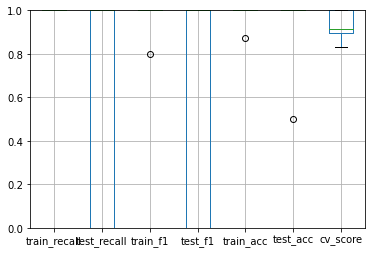

In [391]:
train_recall_lr = []
test_recall_lr = []

train_f1_lr = []
test_f1_lr = []

train_acc_lr = []
test_acc_lr = []

cv_score = []
auc_score = []

for i in range(30):
    gait_label_0 = gait_entropy[gait_entropy['label']==0]
    gait_label_1 = gait_entropy[gait_entropy['label']==1]

    gait_label_0_train = gait_label_0
    gait_label_1_train = gait_label_1

    gait_baseline_model_dataset = pd.concat([gait_label_0_train, gait_label_1_train])

    gait_baseline_model_dataset = shuffle(gait_baseline_model_dataset).reset_index(drop=True) # disrupt the order

    X = gait_baseline_model_dataset.iloc[:, 0:-1]
    Y = gait_baseline_model_dataset.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

    # normalisation
    X_scaler = StandardScaler().fit(X_train)
    standardized_X_train = X_scaler.transform(X_train)
    standardized_X_test = X_scaler.transform(X_test)

    # Initialising the model and training
    # linear_svc = SVC(kernel='linear', C=0.5, class_weight='balanced', random_state=10).fit(X_train, y_train) 
    linear_svc = SVC(kernel='rbf',C=1,gamma=0.5,class_weight = 'balanced',random_state=10).fit(X_train, y_train)    

    # prediction and results
    training = linear_svc.predict(X_train)
    testing=linear_svc.predict(X_test)

    train_recall = recall_score(training,y_train)
    train_f1 = f1_score(training,y_train)
    train_accuracy = accuracy_score(training,y_train)

    test_recall = recall_score(testing,y_test)
    test_f1 = f1_score(testing,y_test)
    test_accuracy = accuracy_score(testing,y_test)

    train_recall_i = train_recall
    test_recall_i = test_recall

    train_f1_i = train_f1
    test_f1_i = test_f1

    train_acc_i = train_accuracy
    test_acc_i = test_accuracy

    train_recall_lr.append(train_recall_i)
    test_recall_lr.append(test_recall_i)
    train_f1_lr.append(train_f1_i)
    test_f1_lr.append(test_f1_i)
    train_acc_lr.append(train_acc_i)
    test_acc_lr.append(test_acc_i)

    cv_scores_i = cross_val_score(linear_svc, X, Y, cv=3)
    cv_score.append(cv_scores_i.mean())

    auc_score_i = average_precision_score(testing,y_test)
    auc_score.append(auc_score_i)

train_recall_lr = pd.DataFrame(train_recall_lr, columns=['train_recall'])
test_recall_lr = pd.DataFrame(test_recall_lr, columns=['test_recall'])
train_f1_lr = pd.DataFrame(train_f1_lr, columns=['train_f1'])
test_f1_lr = pd.DataFrame(test_f1_lr, columns = ['test_f1'])
train_acc_lr = pd.DataFrame(train_acc_lr, columns=['train_acc'])
test_acc_lr = pd.DataFrame(test_acc_lr, columns=['test_acc'])
cv_score = pd.DataFrame(cv_score, columns=['cv_score'])
auc_score = pd.DataFrame(auc_score, columns=['auc_score'])
all_events_recall_logic_reg = pd.concat([train_recall_lr, test_recall_lr, train_f1_lr, test_f1_lr,train_acc_lr,test_acc_lr,cv_score],axis=1)
# all_events_recall_logic_reg = pd.concat([cv_score],axis=1)
# all_events_recall_logic_reg.to_csv('result_baseline_lr.csv')
all_events_recall_logic_reg.boxplot()  
plt.ylim(0,1) 
print(all_events_recall_logic_reg.mean())

In [392]:
cv_score.to_csv('result_entropy_svm.csv')

In [ ]:


import imp
import numpy as np
import pylab as pl

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

iris_dataset = load_iris()

X, Y = iris_dataset.data, iris_dataset.target

# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the trainingset and
# just applying it on the test set.

scaler = StandardScaler()

X = scaler.fit_transform(X)

# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = 10. ** np.arange(-3, 8)
gamma_range = 10. ** np.arange(-5, 4)

param_grid = dict(gamma=gamma_range, C=C_range)

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=StratifiedKFold(y=Y, k=5))

grid.fit(X, Y)

print("The best classifier is: ", grid.best_estimator_)

# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict = grid.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Make a nice figure
pl.figure(figsize=(8, 6))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest', cmap=pl.cm.spectral)
pl.xlabel('gamma')
pl.ylabel('C')
pl.colorbar()
pl.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
pl.yticks(np.arange(len(C_range)), C_range)
pl.show()